# Analyse what happens with different powers

## Now we have to deal with levels crossing over

In [1]:
from sympy.functions.special.error_functions import erf
from fewfermions.simulate.numerics import discrete_hamiltonian
from scipy import sparse

from helpers_merging import *

initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 4*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power*4,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist*2,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

left_cutoff = -0.5*initial_distance-3*float(trap.subs(trap.waist_tweezer1))
right_cutoff = 0.5*initial_distance+3*float(trap.subs(trap.waist_tweezer2))

x, y, z = trap.x, trap.y, trap.z

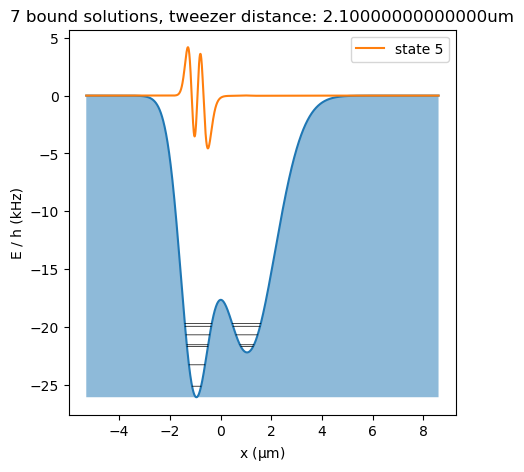

In [2]:
trap[trap.distance_tweezers] = 2.1*si.um#initial_distance
plot_solutions(trap,7,left_cutoff,right_cutoff,display_plot=5,state_mult=40,n_pot_steps=2000,plot=True,ret_results=False)

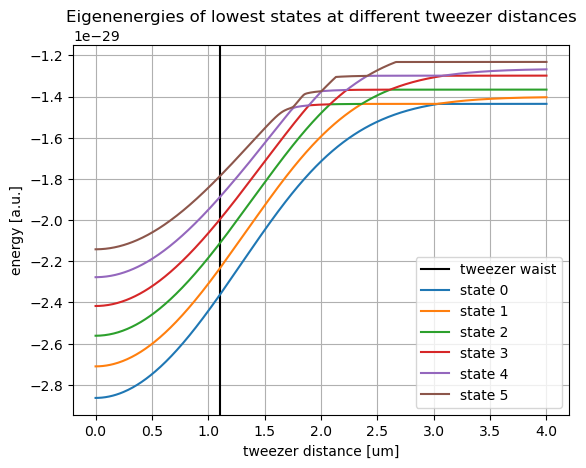

In [3]:
check_crossover = False
n_levels=6
n_pot_steps=2000
crossover_thresh = 0.3
x_np = np.linspace(left_cutoff,right_cutoff,n_pot_steps)

distances = np.linspace(initial_distance,0*si.um,500)
energies = np.zeros((len(distances),n_levels))
states = np.zeros((len(distances),n_levels,n_pot_steps))
potential = np.zeros((len(distances),n_pot_steps))

#inititalise arrays for swapping in case of crossover
swapped_index = np.arange(n_levels)
#diagonalise hamiltonian for all distances
for i, dist in enumerate(distances):
    trap[trap.distance_tweezers] = dist
    num, ener, state, pot = plot_solutions(trap,n_levels,np.min(x_np),np.max(x_np),display_plot=0,state_mult=450,n_pot_steps=n_pot_steps,plot=False,ret_results=True)
    
    if check_crossover:
        # check if there was a crossing of energies
        if i==0:
            prob_left = np.sum(state[:,:int(n_pot_steps/2)]**2,axis=1)
        prob_left_new = np.sum(state[:,:int(n_pot_steps/2)]**2,axis=1)
        #create list of indices to swap
        if np.any(np.abs(prob_left - prob_left_new) > crossover_thresh):
            swap_index = np.where(np.abs(prob_left - prob_left_new)[swapped_index] > crossover_thresh)[0]
            print(f"crossover of states {swap_index} at {dist/si.um:.2f}um")
            """
            if np.sum(np.abs(prob_left - prob_left_new) > crossover_thresh)==1:
                #deal with crossover with state that is not calculated
                swapped_index = np.append(swapped_index,swap_index[0])
                energies = np.concatenate((energies,np.full((len(distances), 1), np.nan)),axis=1)
                swapped_index = np.delete(swapped_index,swap_index)
                #raise Exception('Crossover with state "n_levels". Add that level as well.')"""
            if np.sum(np.abs(prob_left - prob_left_new) > crossover_thresh)==2:
                swapped_index[swap_index] = swapped_index[np.roll(swap_index,1)]

            print(swapped_index)
                
        #swap entries for energes and states
        ener = ener[swapped_index]
        state = state[swapped_index]
        #update prob_left for next loop
        prob_left = np.copy(prob_left_new)

    # fill in arrays
    energies[i,:len(ener)] = ener
    states[i,:len(ener)] = state
    potential[i] = pot(x_np)


#plot eigenenergies
plt.axvline(float(trap.subs(trap.waist_tweezer1))/si.um, color="black",label="tweezer waist")
for i in range(n_levels):
    plt.plot(distances/si.um,energies[:,i],label=f"state {i}")

plt.title("Eigenenergies of lowest states at different tweezer distances")
plt.xlabel("tweezer distance [um]")
plt.ylabel("energy [a.u.]")
#plt.xlim(1.1,2.7)
#plt.ylim(-4.0e-29,-1.5e-29)

plt.grid()
plt.legend()
plt.show()

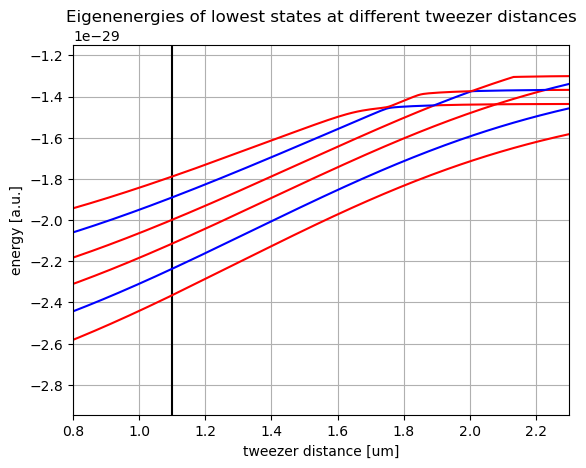

In [4]:
#plot eigenenergies
plt.axvline(float(trap.subs(trap.waist_tweezer1))/si.um, color="black",label="tweezer waist")
for i in range(n_levels):
    #differentiate states that are coming from right and left tweezer
    if np.sum(states[0,i,:int(n_pot_steps/2)]**2) < 0.5:
        plt.plot(distances/si.um,energies[:,i],color="red",label=f"state {i}")
    else:
        plt.plot(distances/si.um,energies[:,i],color="blue",label=f"state {i}")

plt.title("Eigenenergies of lowest states at different tweezer distances")
plt.xlabel("tweezer distance [um]")
plt.ylabel("energy [a.u.]")
plt.xlim(0.8,2.3)
#plt.ylim(-1.2e-28,-0.7e-28)

plt.grid()
#plt.legend()
plt.show()

In [5]:
np.sum(states[:,:,:int(n_pot_steps/2)]**2,axis=2)[:,i].shape

(500,)

In [6]:
x_np.shape

(2000,)

In [7]:
from scipy.signal import find_peaks

[  1 118 121 181 333]
[  1 118 121 203 206 319]
[  1 172 174 178 203 206 238 241 299]
[  1 112 114 172 174 220 222 238 241 262 264 278]
[  1 112 114 197 199 220 222 248 250 262 264 279 282 376]
[  1 165 168 175 197 199 232 234 248 250 267 270 279 282 297]


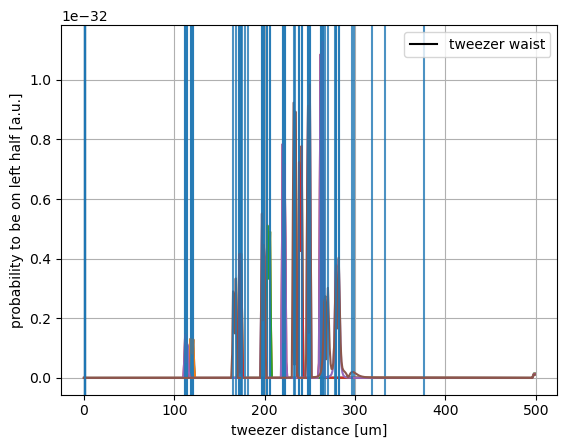

In [8]:
#plot eigenenergies
plt.axvline(float(trap.subs(trap.waist_tweezer1))/si.um, color="black",label="tweezer waist")
for i in range(n_levels):
    #plt.plot(energies[:,i])
    #plt.plot(distances/si.um,energies[:,i],label=f"state {i}")
    #plt.plot(np.sum(states[:,:,:int(n_pot_steps/2)]**2,axis=2)[:,i],label=f"state {i}")
    #plt.plot(np.gradient(np.sum(states[:,:,:int(n_pot_steps/2)]**2,axis=2)[:,i]),label=f"state {i}")
    #grad = np.abs(np.diff(np.sum(states[:,:,:int(n_pot_steps/2)]**2,axis=2)[:,i]))
    grad = np.abs(np.gradient(np.gradient(np.gradient(energies[:,i]))))
    plt.plot(grad)
    index = find_peaks(grad)[0]
    print(index)
    for j, ind in enumerate(index):
        plt.axvline(ind,alpha=0.8)
    #plt.plot(distances/si.um,np.sum(np.gradient(states,axis=0),axis=2)[:,i])
    #plt.plot(distances/si.um,np.gradient(np.gradient(np.gradient(energies[:,i]))))



plt.xlabel("tweezer distance [um]")
plt.ylabel("probability to be on left half [a.u.]")
#plt.xlim(220,330)
#plt.ylim(0,1e-3)


plt.grid()
plt.legend()
plt.show()

[120]
[]
[]
[]
[]
[204]
[]
[]
[]
[173 240]
[]
[]
[113 221 263]
[]
[198 249 280]


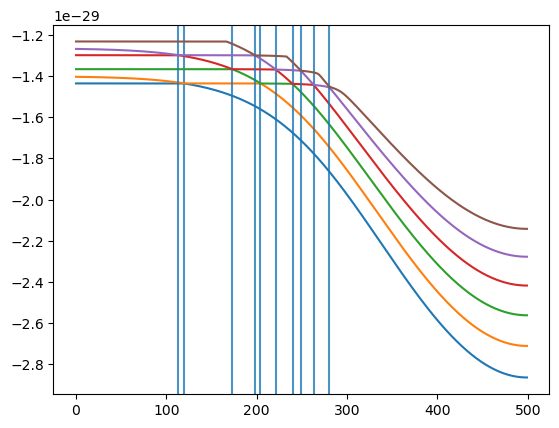

In [9]:
#plot eigenenergies
for i in range(n_levels):
    plt.plot(energies[:,i])
    for j in range(i+1,n_levels):
        diff = np.abs(energies[:,i] - energies[:,j])

        mask = np.where(diff < 1e-1*np.max(diff),diff,1e-1*np.max(diff))
        #plt.plot(mask)
        index = find_peaks(-mask)[0]
        print(index)
        for k, ind in enumerate(index):
            plt.axvline(ind,alpha=0.8)
        

In [10]:
distances = np.linspace(initial_distance,0*si.um,500)
energies, states, potentials = loop_distances(trap, distances)

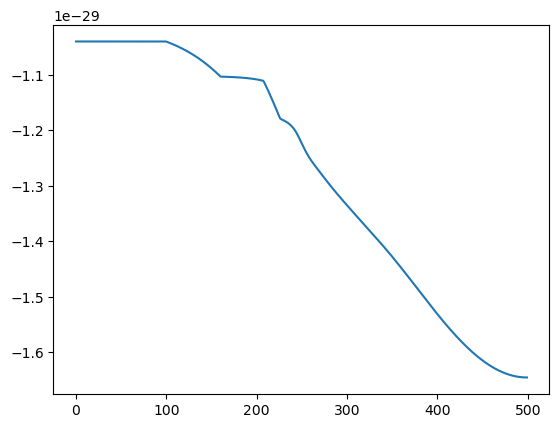

In [15]:
plt.plot(energies[:,-1])

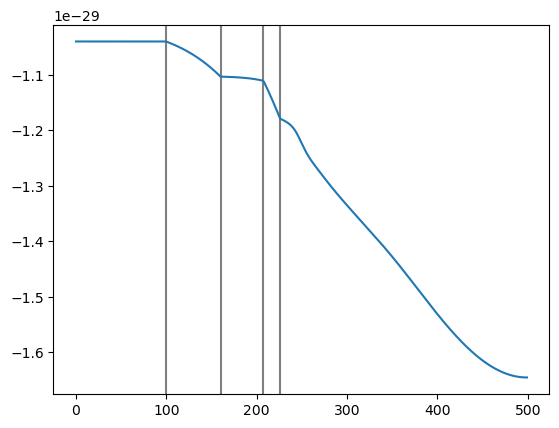

In [27]:
arr = np.abs(np.gradient(np.gradient(energies[:,-1])))
index = find_peaks(arr,width=(1,4))[0]
for i, ind in enumerate(index):
    plt.axvline(ind,color="k",alpha=0.5)
plt.plot(energies[:,-1])